# Case 21.9 Time series data - Forecasting public transportation demands

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from dmba import regressionSummary


DATA = Path('.').resolve().parent / 'data'

# Assignment

For your final model, present the following summary:

- Name of the method/combination of methods.
- A brief description of the method/combination.
- All estimated equations associated with constructing forecasts from this method.
- The MAPE and MAE for the training period and the validation period.
- Forecasts for the future period (March 22-24), in 15-minute bins.
- A single chart showing the fit of the final version of the model to the entire period (including training, validation, and future). Note that this model should be fitted using the combined training plus validation data.

# Load the data

In [2]:
data = pd.read_csv(DATA / 'bicup2006.csv')
print(data.shape)
data.head()

(1512, 3)


,DATE,TIME,DEMAND
0,1-Mar-05,6:30,1.0
1,1-Mar-05,6:45,2.0
2,1-Mar-05,7:00,4.0
3,1-Mar-05,7:15,0.0
4,1-Mar-05,7:30,10.0


## Step 1: Exploratory analysis
- Use exploratory analysis to identify the components of this time series. Is there a trend? Is there seasonality? If so, how many "seasons" are there? Are there any other visible patterns? Are the patterns global (the same throughout the series) or local?
- Consider the frequency of the data from a practical and technical point of view. What are some options?
- Compare the weekdays and weekends. How do they differ? Consider how these differences can be captured by different methods.
- Examine the series for missing values or unusual values. Think of solutions.
- Based on the patterns that you found in the data, which models or methods should be considered?

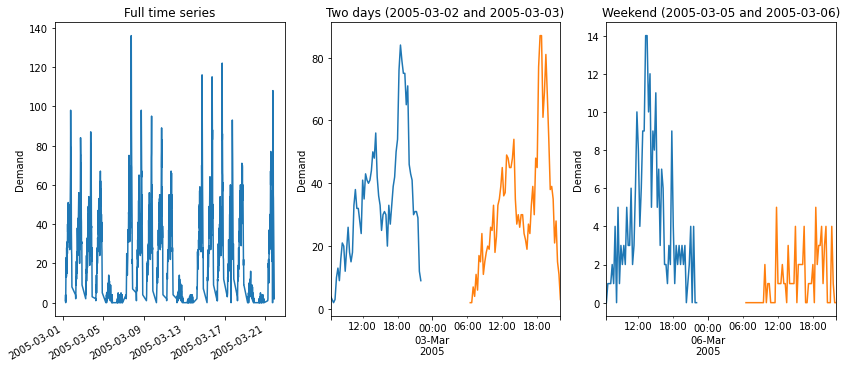

In [3]:
timeSteps = pd.to_datetime(data.DATE + ' ' +data.TIME, infer_datetime_format=True)
ts = pd.Series(data.DEMAND.values, index=timeSteps, name='Demand')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,6))
ts.plot(ax=axes[0])
ts['2005-03-02'].plot(ax=axes[1])
ts['2005-03-03'].plot(ax=axes[1])
ts['2005-03-05'].plot(ax=axes[2])
ts['2005-03-06'].plot(ax=axes[2])
axes[0].set_title('Full time series')
axes[1].set_title('Two days (2005-03-02 and 2005-03-03)')
axes[2].set_title('Weekend (2005-03-05 and 2005-03-06)')
for ax in axes:
    ax.set_ylabel('Demand')
plt.show()

The graph shows no trend. We see a weakly pattern with high demand from Monday to Friday, lower demand on Saturday, and even less demand on Sunday. It seems that the demand is slightly decreasing from Monday to Friday.

The workdays have a bimodal pattern with increasing demand until 14:00, a drop in demand until 16:00, and increasing again with the daily peak from 18:00 to 20:00. Saturdays show only a single peak and Sundays have no discernible pattern due to low demand.

The dataset has two seasonalities that we need to consider in our forecasting, the daily and the weekly seasonality.

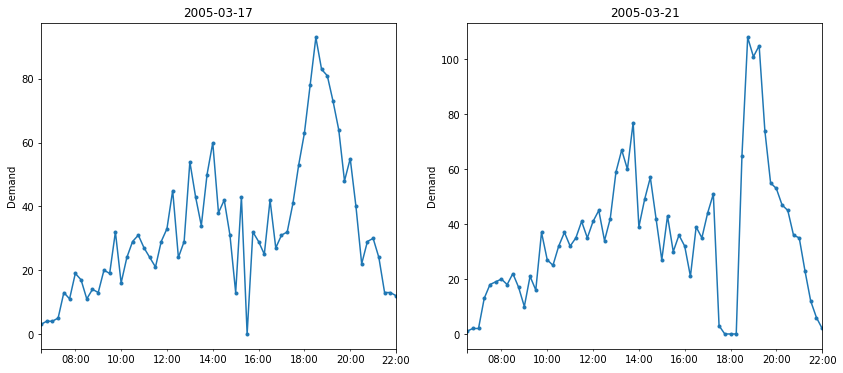

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ts['2005-03-17'].plot(ax=axes[0], style='.-')
ts['2005-03-21'].plot(ax=axes[1], style='.-')
axes[0].set_title('2005-03-17')
axes[1].set_title('2005-03-21')
for ax in axes:
    ax.set_ylabel('Demand')
plt.show()

There are two days with an unusual daily pattern. On 2005-03-17 we see zero demand at 15:30 and on 2005-03-21 three data points with zero demand from 17:45 to 18:15 (the demand of 3 at 17:30 is also highly unusual). It is likely that these are errors in the dataset. There are various options to deal with these data points:

1. use as it: the influence of these 5 data points on the model should be minimal due to the large size of the dataset
2. remove for the model building
3. impute data points: we could for example replace the data points with the average of the two neighboring data points; in the case of 2005-03-21, this would require a linear interpolation for the four unusual data points. It is possible that the next data points are influenced by the cause of the error as well (the low value of 3 at the 17:30 time point is an indication of this), so we may need a more elaborate way of getting reliable estimates.
4. model based imputation of data points: first build a model using either approach (1) or (2) and replace the values using the predictions for these data points

A thorough analysis of the way the data were gathered is required to make the best choice in this case. In the following we use method (1). However, feel free to explore the other three approaches in your solution.

# Step 2: Forecast model
Based on the result from the exploratory analysis, we will create a regression model taking the daily (time of day) and weekly (day of week) seasonality into account.

In [5]:
# combine date and time 
data = data.set_index(pd.to_datetime(data.DATE + ' ' +data.TIME, infer_datetime_format=True))

data = tsatools.add_trend(data, trend='ct')

# add season variables for day of week and time of day
data['DayOfWeek'] = pd.to_datetime(data.DATE + ' ' +data.TIME, infer_datetime_format=True).dt.dayofweek
data['TimeOfDay'] = (data.trend - 1) % 63

data.head()

,DATE,TIME,DEMAND,const,trend,DayOfWeek,TimeOfDay
2005-03-01 06:30:00,1-Mar-05,6:30,1.0,1.0,1.0,1,0.0
2005-03-01 06:45:00,1-Mar-05,6:45,2.0,1.0,2.0,1,1.0
2005-03-01 07:00:00,1-Mar-05,7:00,4.0,1.0,3.0,1,2.0
2005-03-01 07:15:00,1-Mar-05,7:15,0.0,1.0,4.0,1,3.0
2005-03-01 07:30:00,1-Mar-05,7:30,10.0,1.0,5.0,1,4.0


In [6]:
# split into training (18 days), validation set (3 days) and three forecast days (each day contains 63 rows)
pd.set_option('display.width', 1000)
train_df = data.iloc[:(18 * 63),]
print(train_df.tail())
valid_df = data.iloc[(18 * 63):(21 * 63),]
print(valid_df.head())
print(valid_df.tail())
next3days_df = data.iloc[(21 * 63):,]
print(next3days_df.head())
print(next3days_df.tail())

                          DATE   TIME  DEMAND  const   trend  DayOfWeek  TimeOfDay
2005-03-18 21:00:00  18-Mar-05  21:00    19.0    1.0  1130.0          4       58.0
2005-03-18 21:15:00  18-Mar-05  21:15    22.0    1.0  1131.0          4       59.0
2005-03-18 21:30:00  18-Mar-05  21:30    15.0    1.0  1132.0          4       60.0
2005-03-18 21:45:00  18-Mar-05  21:45     9.0    1.0  1133.0          4       61.0
2005-03-18 22:00:00  18-Mar-05  22:00     9.0    1.0  1134.0          4       62.0
                          DATE  TIME  DEMAND  const   trend  DayOfWeek  TimeOfDay
2005-03-19 06:30:00  19-Mar-05  6:30     0.0    1.0  1135.0          5        0.0
2005-03-19 06:45:00  19-Mar-05  6:45     0.0    1.0  1136.0          5        1.0
2005-03-19 07:00:00  19-Mar-05  7:00     1.0    1.0  1137.0          5        2.0
2005-03-19 07:15:00  19-Mar-05  7:15     1.0    1.0  1138.0          5        3.0
2005-03-19 07:30:00  19-Mar-05  7:30     3.0    1.0  1139.0          5        4.0
          

Create a forecast model taking the two seasonalities into account

In [7]:
bicup_lm = sm.ols(formula='DEMAND ~ trend + C(DayOfWeek) * C(TimeOfDay)', data=train_df).fit()
bicup_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DEMAND   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     37.28
Date:                Sat, 23 May 2020   Prob (F-statistic):          4.94e-324
Time:                        15:03:24   Log-Likelihood:                -3358.3
No. Observations:                1134   AIC:                             7601.
Df Residuals:                     692   BIC:                             9825.
Df Model:                         441                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.0585      4.246      0.485      0.628      -6.278      10.395
C(DayOfWeek)[T.1]                         -0.7527      5.465     -0.138      0.891     -11.484       9.978
C(DayOfWeek)[T.2]                         -0.8516      5.465     -0.156      0.876     -11.582       9.878
C(DayOfWeek)[T.3]                         -1.2839      5.465     -0.235      0.814     -12.013       9.446
C(DayOfWeek)[T.4]                         -0.7161      5.465     -0.131      0.896     -11.446      10.013
C(DayOfWeek)[T.5]                         -1.8021      5.987     -0.301      0.763     -13.557       9.952
C(DayOfWeek)[T.6]                         -2.9011      5.986     -0.485      0.628     -14.655       8.853
C(TimeOfDay)[T.1.0]                       -0.5016      5.986     -0.084      0.933     -12.255      11.252
C(TimeOfDay)[T.2.0]                        2.4969      5.986      0.417      0.677      -9.257      14.250
C(TimeOfDay)[T.3.0]                        3.9953      5.986      0.667      0.505      -7.758      15.749
C(TimeOfDay)[T.4.0]                        8.4937      5.986      1.419      0.156      -3.260      20.247
C(TimeOfDay)[T.5.0]                       14.4921      5.986      2.421      0.016       2.739      26.246
C(TimeOfDay)[T.6.0]                       22.4906      5.986      3.757      0.000      10.737      34.244
C(TimeOfDay)[T.7.0]                       14.9890      5.986      2.504      0.013       3.235      26.743
C(TimeOfDay)[T.8.0]                       14.9874      5.986      2.504      0.013       3.234      26.741
C(TimeOfDay)[T.9.0]                       14.4859      5.986      2.420      0.016       2.732      26.239
C(TimeOfDay)[T.10.0]                      17.9843      5.986      3.004      0.003       6.231      29.738
C(TimeOfDay)[T.11.0]                      17.4827      5.986      2.920      0.004       5.729      29.236
C(TimeOfDay)[T.12.0]                      17.4812      5.986      2.920      0.004       5.728      29.235
C(TimeOfDay)[T.13.0]                      17.9796      5.986      3.003      0.003       6.226      29.733
C(TimeOfDay)[T.14.0]                      18.4780      5.986      3.087      0.002       6.724      30.232
C(TimeOfDay)[T.15.0]                      20.9764      5.986      3.504      0.000       9.223      32.730
C(TimeOfDay)[T.16.0]                      24.9749      5.986      4.172      0.000      13.221      36.728
C(TimeOfDay)[T.17.0]                      29.9733      5.986      5.007      0.000      18.220      41.727
C(TimeOfDay)[T.18.0]                      26.4717      5.986      4.422      0.000      14.718      38.225
C(TimeOfDay)[T.19.0]                      33.4702      5.986      5.591      0.000     

Visual inspection of model predictions

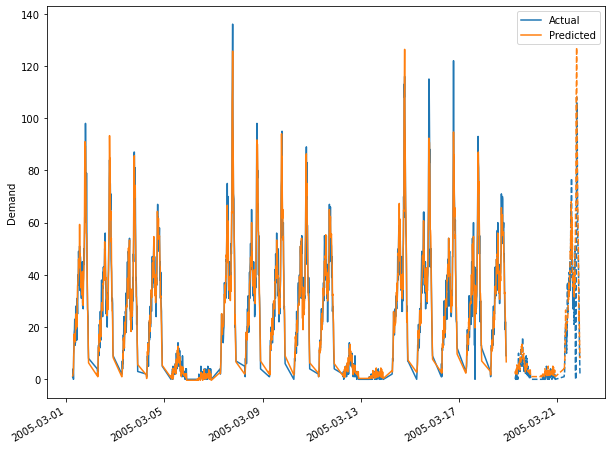

In [8]:
ax = train_df.plot(y='DEMAND', figsize=(10, 8), legend='actual')
bicup_lm.predict(train_df).plot(ax=ax)

valid_df.plot(y='DEMAND', ax=ax, color='C0', linestyle='dashed')
bicup_lm.predict(valid_df).plot(ax=ax, color='C1', linestyle='dashed')

ax.legend(["Actual", "Predicted"]);
ax.set_ylabel('Demand')
plt.show()

# Step 3: Evaluating model performance
Consider how to handle actual counts of zero within the computation of MAPE.


In [9]:
regressionSummary(valid_df['DEMAND'], bicup_lm.predict(valid_df))


Regression statistics

               Mean Error (ME) : -2.7611
Root Mean Squared Error (RMSE) : 12.5111
     Mean Absolute Error (MAE) : 4.9684


By default MAPE is not calculated for actual values that contain 0. If you look at the equation, you will see that actual values occur in the denominator and dividing by zero would lead to an infinite value. The validation set has 39 zero values, three for the unusual spike on 2005-03-21 and during times of very low demand

In [10]:
print('Size of validation set', len(valid_df['DEMAND']))
print('Number of zero values', sum(valid_df['DEMAND'] == 0))

Size of validation set 189
Number of zero values 39


There are a variety of approaches to handle the zero value cases. While not ideal, one approach is to exclude the zero values from the calculation (for a discussion, see e.g. https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape). 

In this case, dropping the zero value might be justified, as there seem to be errors in the data set (see the unusual spike on the third day, 2005-03-21; there is a similar spike on 2005-03-17).

In [11]:
valid_df_no_zero = valid_df[valid_df.DEMAND != 0]
predict_no_zero = bicup_lm.predict(valid_df)[valid_df.DEMAND != 0]
regressionSummary(valid_df_no_zero['DEMAND'], predict_no_zero)


Regression statistics

                      Mean Error (ME) : -1.4188
       Root Mean Squared Error (RMSE) : 7.8790
            Mean Absolute Error (MAE) : 4.2001
          Mean Percentage Error (MPE) : -57.0109
Mean Absolute Percentage Error (MAPE) : 71.6574


# Predict next three days
Retrain model using the full dataset

In [12]:
full_df = data.iloc[:(21 * 63),]
print(full_df.tail())

                          DATE   TIME  DEMAND  const   trend  DayOfWeek  TimeOfDay
2005-03-21 21:00:00  21-Mar-05  21:00    35.0    1.0  1319.0          0       58.0
2005-03-21 21:15:00  21-Mar-05  21:15    23.0    1.0  1320.0          0       59.0
2005-03-21 21:30:00  21-Mar-05  21:30    12.0    1.0  1321.0          0       60.0
2005-03-21 21:45:00  21-Mar-05  21:45     6.0    1.0  1322.0          0       61.0
2005-03-21 22:00:00  21-Mar-05  22:00     2.0    1.0  1323.0          0       62.0


In [13]:
bicup_lm_full = sm.ols(formula='DEMAND ~ trend + C(DayOfWeek) * C(TimeOfDay)', data=full_df).fit()

In [14]:
bicup_lm_full.predict(next3days_df)

2005-03-22 06:30:00     2.201814
2005-03-22 06:45:00     2.535147
2005-03-22 07:00:00     3.201814
2005-03-22 07:15:00     5.201814
2005-03-22 07:30:00     9.868481
                         ...    
2005-03-24 21:00:00    30.201814
2005-03-24 21:15:00    29.201814
2005-03-24 21:30:00    15.535147
2005-03-24 21:45:00    11.535147
2005-03-24 22:00:00     6.535147
Length: 189, dtype: float64

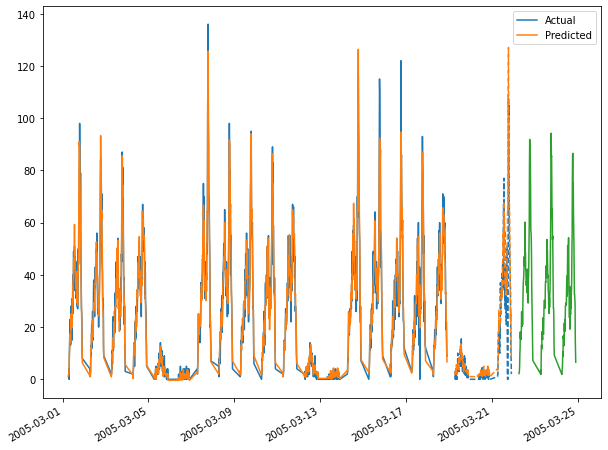

In [15]:
ax = train_df.plot(y='DEMAND', figsize=(10, 8), legend='actual')
bicup_lm.predict(train_df).plot(ax=ax)

valid_df.plot(y='DEMAND', ax=ax, color='C0', linestyle='dashed')
bicup_lm.predict(valid_df).plot(ax=ax, color='C1', linestyle='dashed')

bicup_lm_full.predict(next3days_df).plot(ax=ax)
ax.legend(["Actual", "Predicted"]);
plt.show()